### Full Name : Mahdi Tabatabei 
### Student Number : 400101515


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # Z-score normalization for MNIST
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [2]:
def explore_data(data_loader):
    # Get a batch of data
    images, labels = next(iter(data_loader))  # Get one batch from the data_loader
    
    # Plot sample images
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axes[i].imshow(images[i].squeeze(), cmap="gray")
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')
    plt.suptitle("Sample Images")
    plt.show()

    # Plot label distribution
    labels_list = labels.numpy()
    plt.hist(labels_list, bins=np.arange(11) - 0.5, edgecolor='black')
    plt.xticks(np.arange(10))
    plt.title("Label Distribution in the Batch")
    plt.show()

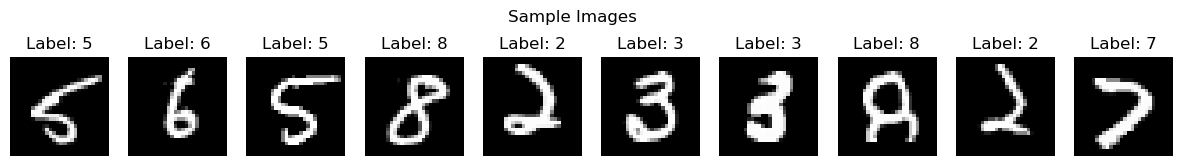

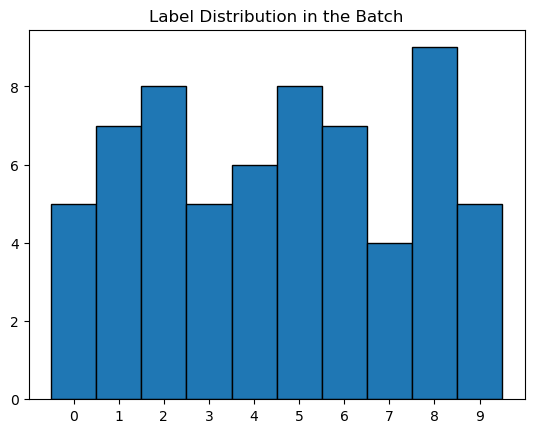

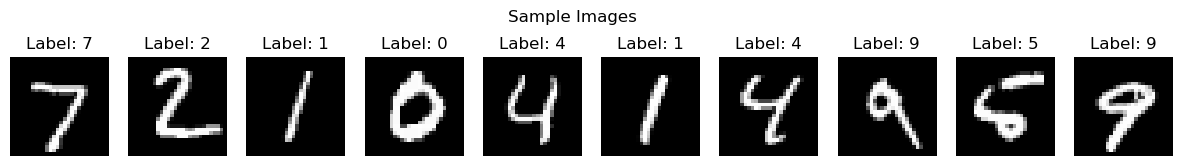

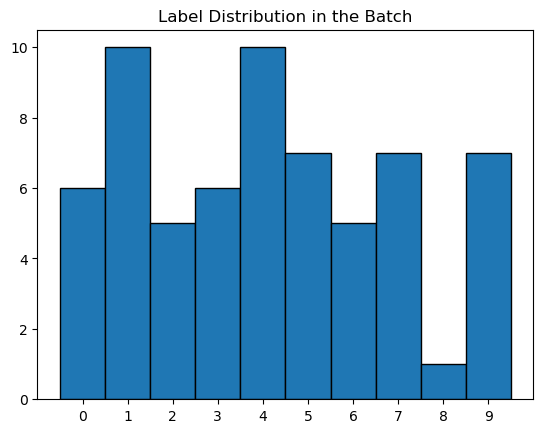

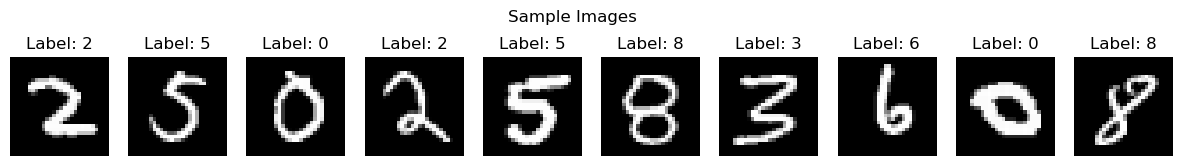

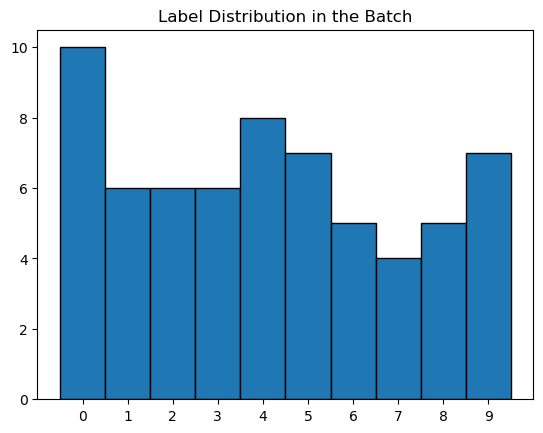

In [3]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)

Prepare the data for use with the CART algorithm by flattening the images.

In [4]:
def prepare_data_for_cart(data_loader):
    X = []
    y = []
    
    # Iterate through the data loader
    for images, labels in data_loader:
        # Flatten the images (each image is 28x28 in MNIST)
        flattened_images = images.view(images.size(0), -1).numpy()  # Convert to 1D and then to numpy
        labels_numpy = labels.numpy()  # Convert labels to numpy array
        
        # Append flattened images and labels to the lists
        X.append(flattened_images)
        y.append(labels_numpy)
    
    # Convert lists to numpy arrays
    X = np.vstack(X)  # Stack vertically all flattened images
    y = np.hstack(y)  # Stack all labels into a single array
    
    return X, y

In [5]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

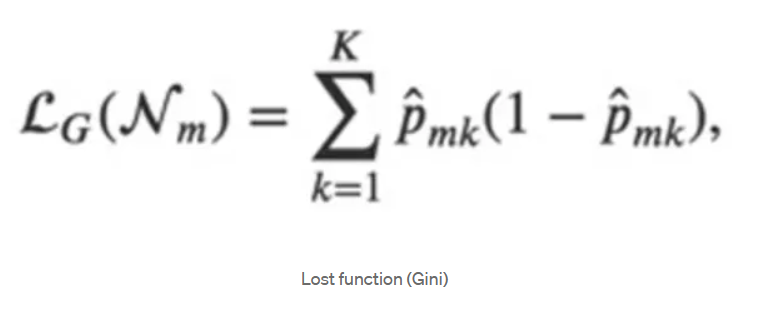

In [6]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        # Stopping conditions
        if depth >= self.max_depth or num_labels == 1 or num_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Find the best split
        feature, threshold = self._find_best_split(X, y)

        if feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Recursively split the dataset
        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold
        left = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left, right=right)

    def _find_best_split(self, X, y):
        num_samples, num_features = X.shape
        best_gini = 1.0  # Gini ranges from 0 (pure) to 1 (impure)
        best_feature, best_threshold = None, None

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                # Split the dataset
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold

                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                # Calculate the weighted Gini impurity
                gini = self._calculate_gini_split(y[left_indices], y[right_indices])

                # Choose the split that minimizes the Gini impurity
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gini_split(self, left_labels, right_labels):
        # Calculate the Gini impurity for the split
        num_samples = len(left_labels) + len(right_labels)
        p_left = len(left_labels) / num_samples
        p_right = len(right_labels) / num_samples

        gini_left = self._gini_impurity(left_labels)
        gini_right = self._gini_impurity(right_labels)

        return p_left * gini_left + p_right * gini_right

    def _gini_impurity(self, y):
        # Gini impurity calculation
        num_samples = len(y)
        if num_samples == 0:
            return 0

        label_counts = np.bincount(y)
        probabilities = label_counts / num_samples
        gini = 1.0 - np.sum(probabilities ** 2)
        return gini

    def _most_common_label(self, y):
        # Find the most common label (for leaf nodes)
        return np.bincount(y).argmax()

    def predict(self, X):
        # Traverse the tree for each sample to predict its label
        return np.array([self._predict_sample(sample, self.root) for sample in X])

    def _predict_sample(self, sample, node):
        # If we reach a leaf node, return its value
        if node.value is not None:
            return node.value

        # Traverse left or right depending on the feature and threshold
        if sample[node.feature] < node.threshold:
            return self._predict_sample(sample, node.left)
        else:
            return self._predict_sample(sample, node.right)


## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

Accuracy of custom DecisionTree_CART: 0.6789
Accuracy of scikit-learn DecisionTreeClassifier: 0.6789


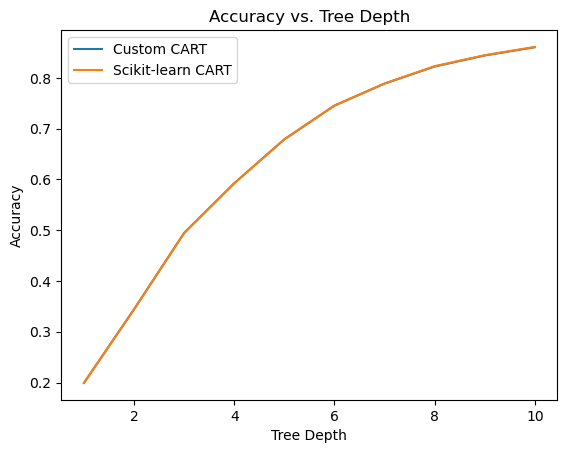

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Step 1: Prepare the data (X_train, y_train, X_test, y_test)
X_train, y_train = prepare_data_for_cart(train_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

# Step 2: Train your implementation of the CART decision tree
tree = DecisionTree_CART(max_depth=5)
tree.fit(X_train, y_train)

# Step 3: Evaluate the performance of your model
predictions = tree.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy of custom DecisionTree_CART: {accuracy:.4f}")

# Step 4: Train scikit-learn's DecisionTreeClassifier and compare performance
sklearn_tree = DecisionTreeClassifier(max_depth=5)
sklearn_tree.fit(X_train, y_train)

# Predictions from scikit-learn's decision tree
sklearn_predictions = sklearn_tree.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
print(f"Accuracy of scikit-learn DecisionTreeClassifier: {sklearn_accuracy:.4f}")

# Step 5: Plot accuracy vs. tree depth for both implementations
depths = range(1, 11)
custom_tree_accuracies = []
sklearn_accuracies = []

for depth in depths:
    # Custom CART
    custom_tree = DecisionTree_CART(max_depth=depth)
    custom_tree.fit(X_train, y_train)
    custom_predictions = custom_tree.predict(X_test)
    custom_tree_accuracies.append(accuracy_score(y_test, custom_predictions))

    # Scikit-learn CART
    sklearn_tree = DecisionTreeClassifier(max_depth=depth)
    sklearn_tree.fit(X_train, y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    sklearn_accuracies.append(accuracy_score(y_test, sklearn_predictions))

# Plot the results
plt.plot(depths, custom_tree_accuracies, label="Custom CART")
plt.plot(depths, sklearn_accuracies, label="Scikit-learn CART")
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Tree Depth')
plt.legend()
plt.show()


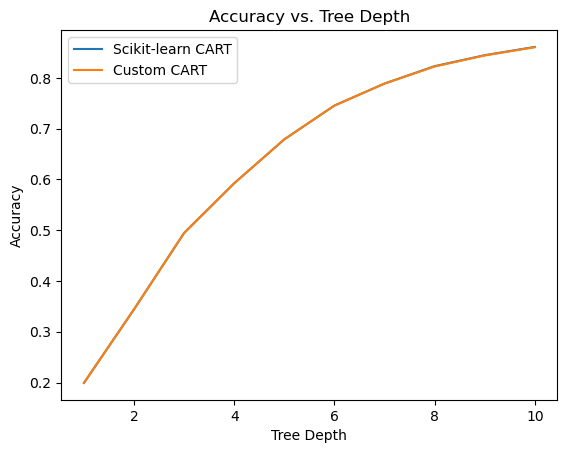

In [9]:
# Plot the results
plt.plot(depths, sklearn_accuracies, label="Scikit-learn CART")
plt.plot(depths, custom_tree_accuracies, label="Custom CART")
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Tree Depth')
plt.legend()
plt.show()

Both are the same.

## Question
What is the difference between ID3 and CART algorithm

**ID3 (Iterative Dichotomiser 3)** and **CART (Classification and Regression Trees)** are both decision tree algorithms, but they differ in several key aspects. Below is a detailed comparison between the two:

### 1. **Type of Problem: Classification vs Regression**
- **ID3**: Primarily designed for **classification problems**. It does not natively support regression tasks.
- **CART**: Can handle both **classification** and **regression problems**. For classification, it produces a **classification tree**, and for regression, it produces a **regression tree**.

### 2. **Splitting Criterion**
- **ID3**: Uses **information gain** based on **entropy** to split the dataset. The feature with the highest information gain is selected.
  - **Entropy Formula**:
    $$
    H(S) = - \sum_{i=1}^{n} p(C_i) \log_2 p(C_i)
    $$
- **CART**: Uses **Gini impurity** (for classification) or **mean squared error (MSE)** (for regression).
  - **Gini Impurity Formula**:
    $$
    G(S) = 1 - \sum_{i=1}^{n} p(C_i)^2
    $$

### 3. **Handling Numeric and Categorical Features**
- **ID3**: Handles **categorical features** natively. Continuous or numeric features need to be discretized.
- **CART**: Handles both **categorical** and **continuous/numeric features** without the need for discretization.

### 4. **Tree Structure**
- **ID3**: Produces **multifurcating** trees, meaning a node can have more than two branches.
- **CART**: Produces **binary trees**, where each node splits into exactly two branches.

### 5. **Handling Missing Values**
- **ID3**: Does not handle missing values natively. Missing data requires preprocessing.
- **CART**: Handles missing values using methods like **surrogate splits**.

### 6. **Pruning Strategy**
- **ID3**: Does not have a built-in pruning mechanism. Pruning is often done as a post-processing step.
- **CART**: Natively supports pruning, particularly **cost-complexity pruning**, which helps prevent overfitting.

### 7. **Algorithm Type**
- **ID3**: A **greedy** top-down recursive algorithm that selects the best attribute at each node using information gain.
- **CART**: Also a **greedy** top-down algorithm but uses Gini impurity or MSE to select the best split, always creating binary splits.

### 8. **Output**
- **ID3**: Outputs a **classification tree**.
- **CART**: Outputs either a **classification tree** or a **regression tree**, depending on the problem.

### 9. **Computational Complexity**
- **ID3**: Can become computationally expensive if there are many categorical features with numerous distinct values.
- **CART**: Generally more efficient due to its binary splitting strategy.

---

### Summary Table:

| Aspect                        | **ID3**                                    | **CART**                                   |
|-------------------------------|--------------------------------------------|--------------------------------------------|
| **Type of Problems**           | Classification                            | Classification and Regression             |
| **Splitting Criterion**        | Information Gain (Entropy)                | Gini Impurity (Classification) <br> MSE (Regression) |
| **Feature Type**               | Categorical                               | Categorical & Continuous                  |
| **Tree Structure**             | Multifurcating                            | Binary                                    |
| **Handling Missing Values**    | Requires preprocessing                    | Handles natively with surrogate splits    |
| **Pruning**                    | No built-in pruning                       | Supports pruning (cost complexity pruning)|
| **Output**                     | Class labels only                         | Class labels (classification) <br> Continuous values (regression) |
| **Computational Complexity**   | More complex with many categorical values | More efficient due to binary splits       |
